# Version 2 Description:
1. in this version i will forecast long term intrest rates using wage data also
2. due to the fact that wages data not collected for all coutries we will have less countries in the sample but with another explanatory variable

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
conn = sqlite3.connect('/Users/Mark Rozenberg/Downloads/Macro-Indicators/macro_indicators_v2.db')

## Part 1 - Data Preparation

### 1.a - add lag's for independent variables (features) in main table

In [2]:
conn.execute(''' drop table if exists main_table_with_lag_v2 ''')
conn.execute('''
create table main_table_with_lag_v2 as
select country, time_period, irlt, share, unemp, wage, cpi, cci,
lag(share) over(partition by country order by cast(time_period as date)) as lag_share,
lag(unemp) over(partition by country order by cast(time_period as date)) as lag_unemp,
lag(wage) over(partition by country order by cast(time_period as date)) as lag_wage,
lag(cpi) over(partition by country order by cast(time_period as date)) as lag_cpi,
lag(cci) over(partition by country order by cast(time_period as date)) as lag_cci,
-- period t-2:
lag(share,2) over(partition by country order by cast(time_period as date)) as lag2_share,
lag(unemp,2) over(partition by country order by cast(time_period as date)) as lag2_unemp,
lag(wage,2) over(partition by country order by cast(time_period as date)) as lag2_wage,
lag(cpi,2) over(partition by country order by cast(time_period as date)) as lag2_cpi,
lag(cci,2) over(partition by country order by cast(time_period as date)) as lag2_cci,
-- period t-3:
lag(share,3) over(partition by country order by cast(time_period as date)) as lag3_share,
lag(unemp,3) over(partition by country order by cast(time_period as date)) as lag3_unemp,
lag(wage,3) over(partition by country order by cast(time_period as date)) as lag3_wage,
lag(cpi,3) over(partition by country order by cast(time_period as date)) as lag3_cpi,
lag(cci,3) over(partition by country order by cast(time_period as date)) as lag3_cci
from main_table
''')
conn.commit()

In [3]:
pd.read_sql('SELECT * FROM main_table_with_lag limit 5', conn)

,country,time_period,irlt,share,unemp,cpi,cci,lag_share,lag_unemp,lag_cpi,lag_cci,lag2_share,lag2_unemp,lag2_cpi,lag2_cci,lag3_share,lag3_unemp,lag3_cpi,lag3_cci
0,ARG,2017-12,None,None,None,24.79560,None,None,None,NaN,None,None,None,NaN,None,None,None,NaN,None
1,ARG,2018-01,None,None,None,25.00623,None,None,None,24.79560,None,None,None,NaN,None,None,None,NaN,None
2,ARG,2018-02,None,None,None,25.43711,None,None,None,25.00623,None,None,None,24.79560,None,None,None,NaN,None
3,ARG,2018-03,None,None,None,25.39652,None,None,None,25.43711,None,None,None,25.00623,None,None,None,24.79560,None
4,ARG,2018-04,None,None,None,25.49816,None,None,None,25.39652,None,None,None,25.43711,None,None,None,25.00623,None


### 1.b - checks missing data

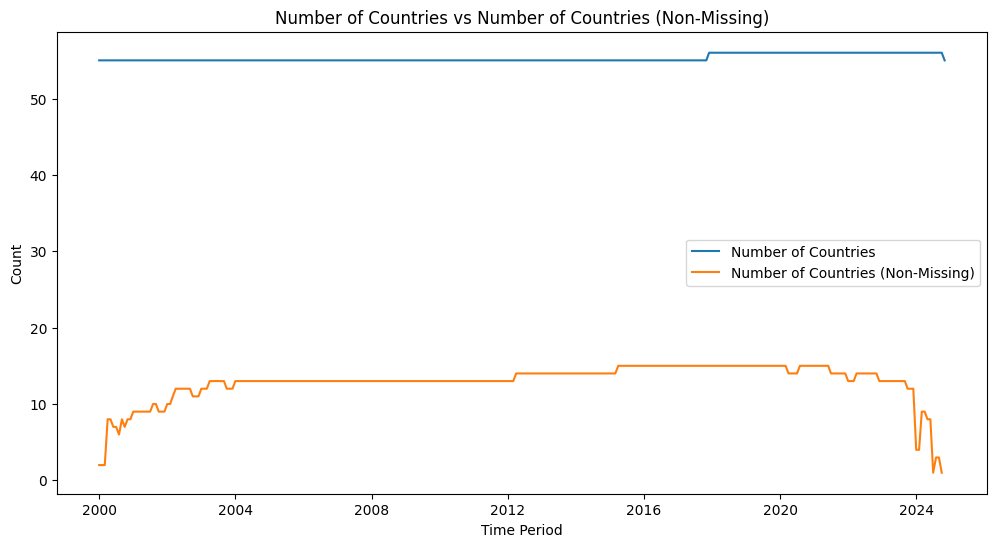

In [4]:
test1 = pd.read_sql_query('''
with part1 as (
select time_period,
count(distinct country) as num_countries
from main_table_with_lag_v2
group by 1
),
part2 as (
select time_period,
count(distinct country) as num_countries_non_missing
from main_table_with_lag_v2
where irlt is not null and share is not null and unemp is not null and wage is not null and cpi is not null and cci is not null
and lag_share is not null and lag_unemp is not null and lag_wage is not null and lag_cpi is not null and lag_cci is not null
and lag2_share is not null and lag2_unemp is not null and lag2_wage is not null and lag2_cpi is not null and lag2_cci is not null
and lag3_share is not null and lag3_unemp is not null and lag3_wage is not null and lag3_cpi is not null and lag3_cci is not null
group by 1
)
select part1.time_period, part1.num_countries, part2.num_countries_non_missing
from part1
left join part2 on part1.time_period = part2.time_period
''', conn)
plt.figure(figsize=(12, 6))
test1['time_period'] = pd.to_datetime(test1['time_period'])
plt.plot(test1['time_period'], test1['num_countries'], label='Number of Countries')
plt.plot(test1['time_period'], test1['num_countries_non_missing'], label='Number of Countries (Non-Missing)')
plt.xlabel('Time Period')
plt.ylabel('Count')
plt.title('Number of Countries vs Number of Countries (Non-Missing)')
plt.legend()
plt.show()

### part 1.c - graphical exploration (i will use subset of countries)

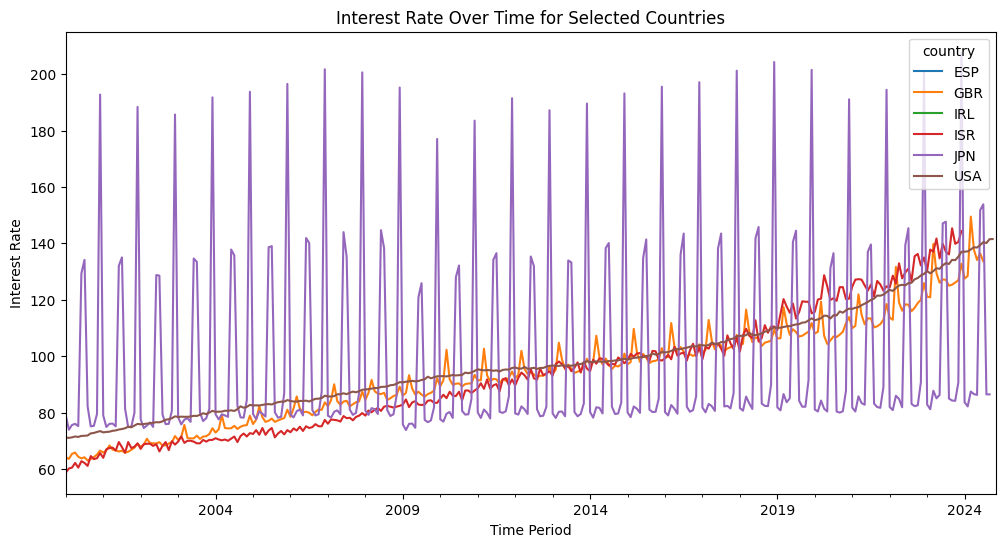

In [ ]:
# graph-1: wages
gra = pd.read_sql_query('''
select time_period, country, wage
from main_table_with_lag_v2
where country in('ISR','IRL','USA','JPN','GBR','ESP')
''', conn)
gra['time_period'] = pd.to_datetime(gra['time_period'])
gra_pivot = gra.pivot(index='time_period', columns='country', values='wage')
gra_pivot.plot(figsize=(12, 6), legend=True)
plt.xlabel('Time Period')
plt.ylabel('Interest Rate')
plt.title('Interest Rate Over Time for Selected Countries')
plt.show()

## Part 2 - Preparing data for forecasting

### 2.a - extract data subset
note: only countries that have a full set of variables with non missing data

In [6]:
pd.read_sql_query('''
select count(distinct country) as num_countries
from main_table_with_lag_v2
''', conn)

,num_countries
0,56


In [8]:
pd.read_sql_query('''
select count(distinct country) as num_countries
from main_table_with_lag_v2
where irlt is not null
and share is not null and unemp is not null and wage is not null and cpi is not null and cci is not null
and lag_share is not null and lag_unemp is not null and lag_wage is not null and lag_cpi is not null and lag_cci is not null
and lag2_share is not null and lag2_unemp is not null and lag2_wage is not null and lag2_cpi is not null and lag2_cci is not null
and lag3_share is not null and lag3_unemp is not null and lag3_wage is not null and lag3_cpi is not null and lag3_cci is not null
and cast(substr(time_period, 1, 4) as int) between 2005 and 2023
''', conn)

,num_countries
0,15


In [9]:
pd.read_sql_query('''
with part1 as (
select * from main_table_with_lag_v2
where irlt is not null
and share is not null and unemp is not null and wage is not null and cpi is not null and cci is not null
and lag_share is not null and lag_unemp is not null and lag_wage is not null and lag_cpi is not null and lag_cci is not null
and lag2_share is not null and lag2_unemp is not null and lag2_wage is not null and lag2_cpi is not null and lag2_cci is not null
and lag3_share is not null and lag3_unemp is not null and lag3_wage is not null and lag3_cpi is not null and lag3_cci is not null
and cast(substr(time_period, 1, 4) as int) between 2005 and 2023
)
select country, count(distinct time_period) as num_periods
from part1
group by 1
order by 2
''', conn)

,country,num_periods
0,HRV,105
1,ISR,141
2,JPN,198
3,AUT,212
4,ITA,221
5,BGR,228
6,GBR,228
7,HUN,228
8,LUX,228
9,NLD,228


In [10]:
main_data = pd.read_sql_query('''
with part1 as (
select * from main_table_with_lag_v2
where irlt is not null
and share is not null and unemp is not null and wage is not null and cpi is not null and cci is not null
and lag_share is not null and lag_unemp is not null and lag_wage is not null and lag_cpi is not null and lag_cci is not null
and lag2_share is not null and lag2_unemp is not null and lag2_wage is not null and lag2_cpi is not null and lag2_cci is not null
and lag3_share is not null and lag3_unemp is not null and lag3_wage is not null and lag3_cpi is not null and lag3_cci is not null
and cast(substr(time_period, 1, 4) as int) between 2005 and 2023
),
part2 as(
select country, count(distinct time_period) as num_periods
from part1
group by 1
)
select *
from part1
where country in(select country from part2 where num_periods = 228)
''', conn)

In [11]:
print(f"Number of unique countries in main_data: {main_data['country'].nunique()}")
print(f"List of unique countries: {main_data['country'].unique()}")
print(main_data.shape)
# print(main_data.columns)

Number of unique countries in main_data: 10
List of unique countries: ['BGR' 'GBR' 'HUN' 'LUX' 'NLD' 'POL' 'SVK' 'SVN' 'SWE' 'USA']
(2280, 23)


### 2.b - correlation matrix


In [12]:
dest = 'C:/Users/Mark Rozenberg/LTINT-Forecast/Data/'

# Create a correlation matrix for the combined data
correlation_matrix = main_data.drop(columns=['time_period','country']).corr()

# Save the correlation matrix to Excel
correlation_matrix.to_excel(dest + 'CorrMatrix-v2.xlsx', sheet_name='All_Countries')

### 2.c - pivot the data
note: each combination of country and parameter will be in separate columns

In [13]:
main_data_pivot = pd.pivot_table(main_data,
values=['irlt', 'share', 'unemp', 'wage', 'cpi', 'cci',
        'lag_share', 'lag_unemp', 'lag_wage', 'lag_cpi', 'lag_cci',
        'lag2_share', 'lag2_unemp', 'lag2_wage', 'lag2_cpi', 'lag2_cci',
        'lag3_share', 'lag3_unemp', 'lag3_wage', 'lag3_cpi', 'lag3_cci'],
index=['time_period'],
columns=['country'], aggfunc="max")
# transform column names from tuple to string
main_data_pivot.columns = ['_'.join(x) for x in main_data_pivot.columns]
main_data_pivot = main_data_pivot.reset_index()
print(main_data_pivot.shape)
# drop rows with null's:
main_data_pivot = main_data_pivot.dropna()
print(main_data_pivot.shape)
main_data_pivot.head()

(228, 211)
(228, 211)


,time_period,cci_BGR,cci_GBR,cci_HUN,cci_LUX,cci_NLD,cci_POL,cci_SVK,cci_SVN,cci_SWE,...,wage_BGR,wage_GBR,wage_HUN,wage_LUX,wage_NLD,wage_POL,wage_SVK,wage_SVN,wage_SWE,wage_USA
0,2005-01,-17.7,-4.4,-15.6,-1.4,-11.7,-8.8,-17.5,-10.9,1.9,...,35.93628,75.91022,51.29003,89.17359,82.19676,56.65380,58.09077,63.73174,74.05247,82.49874
1,2005-02,-18.4,-3.3,-17.8,-3.7,-9.0,-10.2,-16.4,-11.3,1.6,...,37.54143,77.45677,51.06903,85.09161,82.41556,56.16229,60.91540,63.95654,73.58601,82.54899
2,2005-03,-16.7,-2.4,-16.5,-2.0,-10.6,-10.4,-14.6,-14.5,2.2,...,35.96231,82.22533,54.84151,90.25760,82.41556,58.72335,59.54881,61.82091,74.28571,82.49874
3,2005-04,-18.8,-3.4,-20.6,-4.1,-7.0,-10.2,-12.2,-10.7,-0.8,...,37.60123,78.35893,53.62243,91.02457,82.56143,59.05965,57.25814,63.16973,75.04373,82.69971
4,2005-05,-14.0,-4.6,-22.8,-4.6,-11.6,-7.7,-12.9,-11.8,-0.2,...,41.00221,76.68349,57.16860,101.27460,82.41556,58.56813,59.50669,62.83252,75.56851,82.90069


### 2.d - split into train and test

In [14]:
train = main_data_pivot[main_data_pivot['time_period'] <= '2020-01']
test = main_data_pivot[main_data_pivot['time_period'] > '2020-01']
train = train.set_index('time_period')
test = test.set_index('time_period')
train.dropna()
test.dropna()
print(train.shape)
print(test.shape)
print('train start: ', min(list(train.index)))
print('train end: ', max(list(train.index)))
print('test start: ', min(list(test.index)))
print('test end: ', max(list(test.index)))

(181, 210)
(47, 210)
train start:  2005-01
train end:  2020-01
test start:  2020-02
test end:  2023-12


### 2.e - split train and test data into x and y

In [16]:
# choose the country for which we will do the analysis
test_count = 'USA'
y_train = train[['irlt_' + test_count]]
x_train = train[[c for c in train.columns if c not in ['irlt_' + test_count]]]
x_test = test[[c for c in test.columns if c not in ['irlt_' + test_count]]]
y_test = test[['irlt_' + test_count]]
# drop time columns:
# x_train = x_train.drop(columns=['time'])
# x_test = x_test.drop(columns=['time'])
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)
list(x_train.columns) == list(x_test.columns)

(181, 1)
(181, 209)
(47, 1)
(47, 209)


True

## part 3 - Forecasting models

In [17]:
# this table will hold the testing metrics from the various models
# del Compare_Table
Compare_Table = pd.DataFrame(columns=['Model','MAE','MSE','EVS','COD'])

### 3.a - Version 1 - Linear Regression with full set of features

In [18]:
reg = LinearRegression().fit(x_train, y_train)
forec_Mod1 = reg.predict(x_test)
# print(reg.coef_)
# print(reg.intercept_)
# print(reg.score(x_train, y_train))
new_row = pd.DataFrame([{'Model': 'LR with features',
                                      'MAE':mean_absolute_error(y_test, forec_Mod1),
                                      'MSE':mean_squared_error(y_test, forec_Mod1),
                                      'EVS':explained_variance_score(y_test, forec_Mod1),
                                      'COD':r2_score(y_test, forec_Mod1)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_20996\3296953933.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)


### 3.b - Version 2 - Sarimax with full set of features

In [19]:
ARMAmodel = SARIMAX(y_train, order = (1, 1, 1), exog=x_train).fit()
# forec_Mod2 = ARMAmodel.predict(start = y_test.index[0], end = y_test.index[0], exog=x_test)
forec_Mod2 = ARMAmodel.predict(start = '2020-02', end = '2023-12', exog=x_test)
new_row = pd.DataFrame([{'Model': 'Sarimax with features',
                                      'MAE':mean_absolute_error(y_test, forec_Mod2),
                                      'MSE':mean_squared_error(y_test, forec_Mod2),
                                      'EVS':explained_variance_score(y_test, forec_Mod2),
                                      'COD':r2_score(y_test, forec_Mod2)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
Compare_Table

,Model,MAE,MSE,EVS,COD
0,LR with features,1.984227,5.421136,-1.884209,-2.184925
1,Sarimax with features,1.984227,5.421136,-1.884209,-2.184925


### 3.c - reduce number of features using elimination technique

In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model

# Perform stepwise regression: for best subset of indepndent variables
sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                k_features=(2,70),
                                forward=True,
                                scoring='neg_root_mean_squared_error',
                                cv=0)
selected_features = sfs.fit(x_train, y_train)

best selection number of vars: 70
best combination (ACC: -0.053): (1, 2, 5, 6, 7, 9, 13, 15, 19, 20, 21, 24, 25, 26, 28, 37, 44, 46, 50, 52, 54, 55, 56, 59, 64, 67, 71, 84, 88, 89, 91, 92, 94, 96, 97, 98, 102, 103, 107, 111, 113, 116, 118, 122, 123, 124, 129, 132, 133, 138, 140, 143, 145, 151, 154, 156, 159, 167, 173, 174, 175, 178, 181, 184, 186, 193, 194, 197, 199, 206)

best features names:  ('cci_GBR', 'cci_HUN', 'cci_POL', 'cci_SVK', 'cci_SVN', 'cci_USA', 'cpi_LUX', 'cpi_POL', 'cpi_USA', 'irlt_BGR', 'irlt_GBR', 'irlt_NLD', 'irlt_POL', 'irlt_SVK', 'irlt_SWE', 'lag2_cci_SWE', 'lag2_cpi_POL', 'lag2_cpi_SVN', 'lag2_share_GBR', 'lag2_share_LUX', 'lag2_share_POL', 'lag2_share_SVK', 'lag2_share_SVN', 'lag2_unemp_BGR', 'lag2_unemp_POL', 'lag2_unemp_SWE', 'lag2_wage_HUN', 'lag3_cci_POL', 'lag3_cci_USA', 'lag3_cpi_BGR', 'lag3_cpi_HUN', 'lag3_cpi_LUX', 'lag3_cpi_POL', 'lag3_cpi_SVN', 'lag3_cpi_SWE', 'lag3_cpi_USA', 'lag3_share_LUX', 'lag3_share_NLD', 'lag3_share_SWE', 'lag3_unemp_HUN', 'lag3

c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:892: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

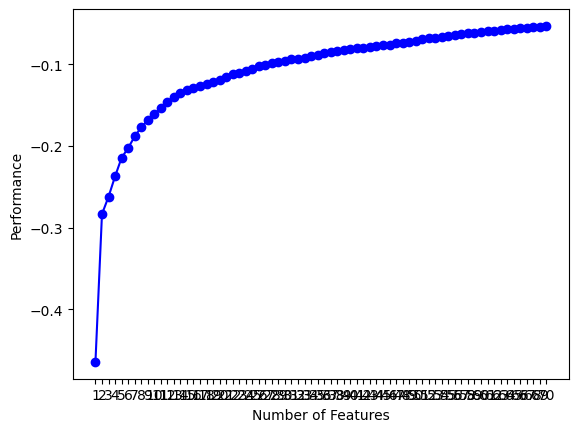

In [22]:
print('best selection number of vars:', len(selected_features.k_feature_names_))
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
print('best features names: ', sfs.k_feature_names_)
plot_sfs(sfs.get_metric_dict(), kind='std_err')

In [23]:
x_test_v2 = x_test[list(sfs.k_feature_names_)]
x_train_v2 = x_train[list(sfs.k_feature_names_)]
print(x_test_v2.shape)
print(x_train_v2.shape)

(47, 70)
(181, 70)


### 3.d - Version 3 - Linear Regression with reduced form of features

In [24]:
reg = LinearRegression().fit(x_train_v2, y_train)
forec_Mod3 = reg.predict(x_test_v2)
# print(reg.coef_)
# print(reg.intercept_)
# print(reg.score(x_train, y_train))
new_row = pd.DataFrame([{'Model': 'LR with features reduced form',
                                      'MAE':mean_absolute_error(y_test, forec_Mod3),
                                      'MSE':mean_squared_error(y_test, forec_Mod3),
                                      'EVS':explained_variance_score(y_test, forec_Mod3),
                                      'COD':r2_score(y_test, forec_Mod3)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

### 3.e - Version 4 - Sarimax with reduced form of features

In [25]:
ARMAmodel = SARIMAX(y_train, order = (1, 1, 1), exog=x_train_v2).fit()
forec_Mod4 = ARMAmodel.predict(start = '2020-02', end = '2023-12', exog=x_test_v2)
new_row = pd.DataFrame([{'Model': 'Sarimax with features reduced form',
                                      'MAE':mean_absolute_error(y_test, forec_Mod4),
                                      'MSE':mean_squared_error(y_test, forec_Mod4),
                                      'EVS':explained_variance_score(y_test, forec_Mod4),
                                      'COD':r2_score(y_test, forec_Mod4)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Part 4 - results summary

In [26]:
Compare_Table

,Model,MAE,MSE,EVS,COD
0,LR with features,1.984227,5.421136,-1.884209,-2.184925
1,Sarimax with features,1.984227,5.421136,-1.884209,-2.184925
2,LR with features reduced form,0.993976,1.190252,0.658280,0.300725
3,Sarimax with features reduced form,0.765561,0.697347,0.822506,0.590308


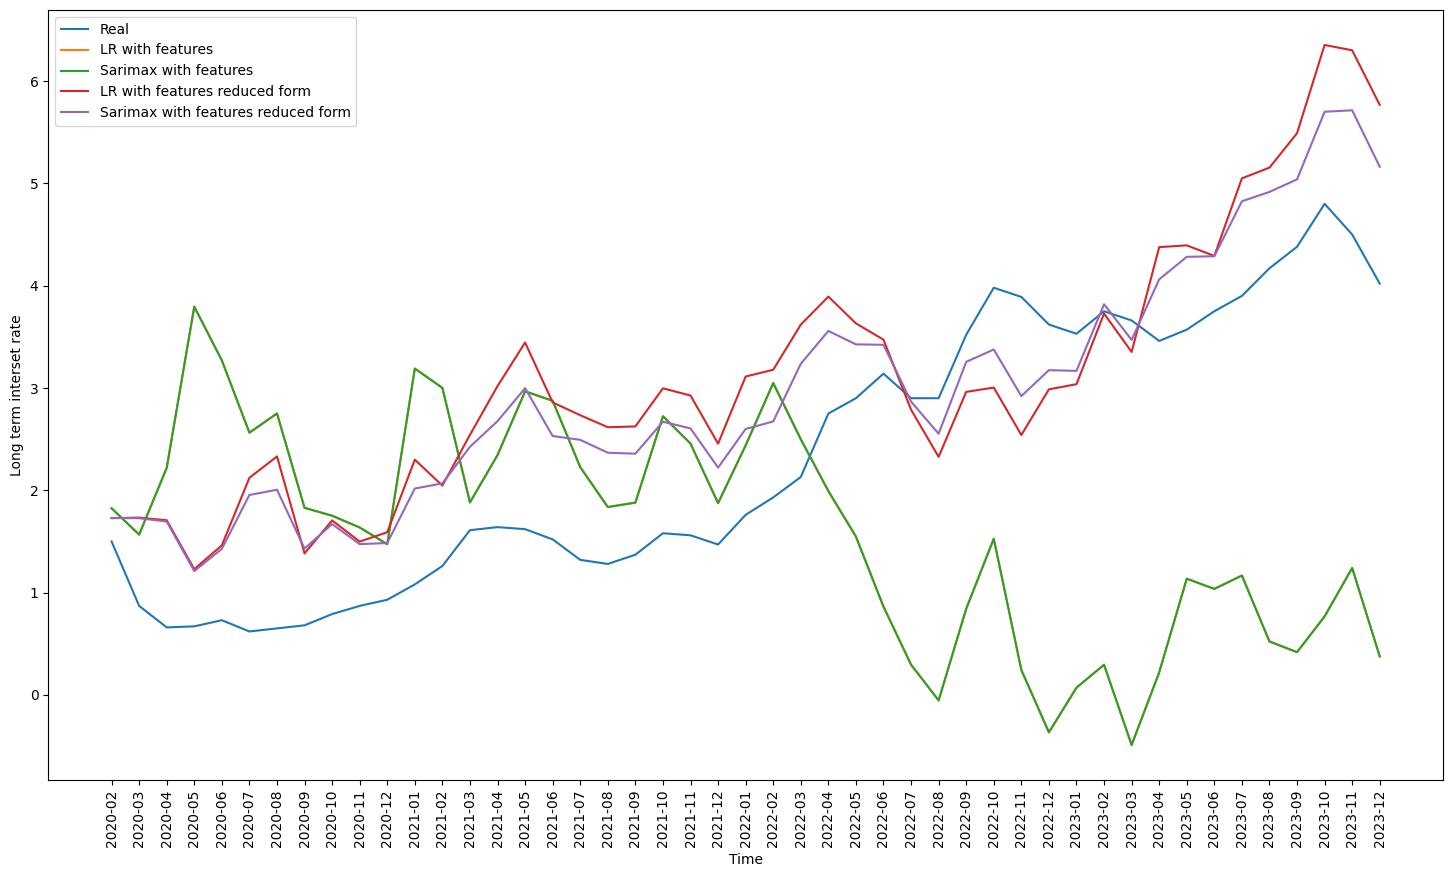

In [27]:
x_axis = test.index
plt.figure(figsize=(18, 10))
plt.plot(x_axis, y_test, label = 'Real')
plt.plot(x_axis, forec_Mod1, label = 'LR with features')
plt.plot(x_axis, forec_Mod2, label = 'Sarimax with features')
plt.plot(x_axis, forec_Mod3, label = 'LR with features reduced form')
plt.plot(x_axis, forec_Mod4, label = 'Sarimax with features reduced form')
plt.xlabel('Time');
plt.ylabel('Long term interset rate');
plt.xticks(rotation=90);
plt.legend();